# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [12]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

user_count = 1000.0
desktop_users = int((1/4)*user_count)
mobile_users = int((3/4)*user_count)

for _ in range(desktop_users):
    # Desktop users
    time_on_site = random.uniform(10, 600)
    purchased = random.random() < 0.1 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, False))
  
for _ in range(mobile_users):
    # Mobile users
    time_on_site = random.uniform(5, 300)
    purchased = random.random() < 0.2 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=276.9700934767833, mobile=True), User(purchased=False, time_on_site=187.55340059464294, mobile=True), User(purchased=False, time_on_site=253.33116900288135, mobile=True), User(purchased=True, time_on_site=207.74074485361749, mobile=False), User(purchased=True, time_on_site=241.97740989699577, mobile=True), User(purchased=True, time_on_site=269.59432144097224, mobile=True), User(purchased=True, time_on_site=294.0130503292321, mobile=True), User(purchased=False, time_on_site=108.83814315757766, mobile=True), User(purchased=False, time_on_site=217.32159769597712, mobile=True), User(purchased=False, time_on_site=9.792904563907905, mobile=True)]


In [13]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,276.970093,True
1,False,187.553401,True
2,False,253.331169,True
3,True,207.740745,False
4,True,241.977410,True


In [14]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.523395633613183,5.91922729321219,6.913594757159657,7.241930090793651,7.3854759049726155,8.04867065471391,9.792904563907905,10.189447262863212,11.516382054416482,11.706420835774926,...,573.1550714674758,575.3074663980381,575.910103710396,579.9344161537639,580.5538520236981,583.4316854081177,585.3082868379222,586.5840603032814,595.2360651099401,595.5398050644333
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,1,1
True,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,1,0,0


In [16]:
pd.crosstab(user_data['purchased'], user_data['mobile'])

mobile,False,True
purchased,,
False,166,527
True,84,223


In [31]:
did_not_purchase_count = pd.crosstab(user_data['purchased'], user_data['mobile'])._xs(key=0).sum()
did_purchase_count = pd.crosstab(user_data['purchased'], user_data['mobile'])._xs(key=1).sum()

In [51]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them
time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(0.0822, 2.059]","(2.059, 4.025]","(4.025, 5.992]","(5.992, 7.959]","(7.959, 9.926]"
purchased,,,,,
False,128,240,272,27,26
True,70,102,86,28,21


In [52]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(0.0822, 2.059]","(2.059, 4.025]","(4.025, 5.992]","(5.992, 7.959]","(7.959, 9.926]"
purchased,,,,,
False,0.646465,0.701754,0.759777,0.490909,0.553191
True,0.353535,0.298246,0.240223,0.509091,0.446809


In [53]:
# That seems counter to our hypothesis
# More time on the site can have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.664,0.702667
True,0.336,0.297333


In [54]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,0.170303,-0.036300
time_on_site,0.170303,1.000000,-0.498221
mobile,-0.036300,-0.498221,1.000000


In [55]:
a = time_bins
b = user_data['purchased']
c = user_data['mobile']
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

In [66]:
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

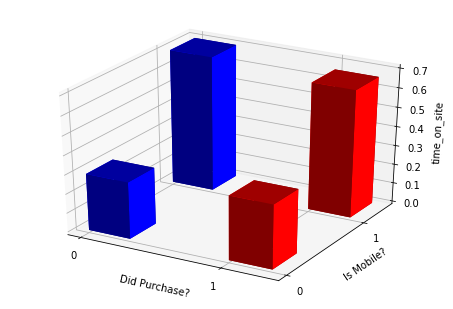

In [111]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2 
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [153]:
tab = pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')
tab

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

In [154]:
tab.index.categories

IntervalIndex([(0.0822, 2.059], (2.059, 4.025], (4.025, 5.992], (5.992, 7.959], (7.959, 9.926]]
              closed='right',
              dtype='interval[float64]')

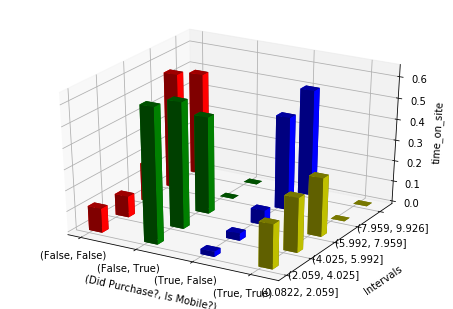

In [181]:
from mpl_toolkits.mplot3d import Axes3D
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

tab = pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')
data = tab.values

column_names = [str(combination) for combination in it.product(*tab.columns.levels)]
row_names = list(map(lambda l: str(l), tab.index.categories))

fig = plt.figure()
ax = Axes3D(fig)

lx= 4
ly= 5
xpos = np.array([0,1,2,3])
ypos = np.array([0,1,2,3,4])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.24 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'g', 'b', 'y'] * ly

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)

ax.xaxis._axinfo['label']['space_factor'] = 2.8

ax.w_xaxis.set_ticklabels(column_names)
ax.w_yaxis.set_ticklabels(row_names, linespacing=5)
ax.axes.set_xticks(np.array([0,1,2,3]))
ax.axes.set_yticks(np.array([0,1,2,3,4]))
ax.set_xlabel('(Did Purchase?, Is Mobile?)', labelpad=10)
ax.set_ylabel('Intervals',  labelpad=20)
ax.set_zlabel('time_on_site')

plt.show()

In [114]:
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.664,0.702667
True,0.336,0.297333


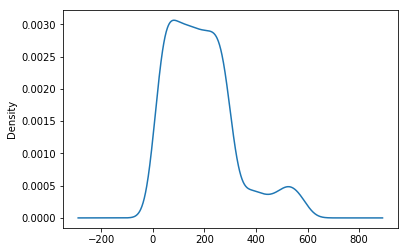

In [71]:
user_data['time_on_site'].plot.density()

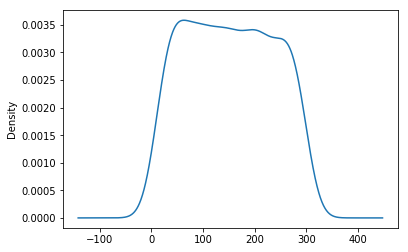

In [73]:
user_data.loc[user_data['mobile'] == True, 'time_on_site'].plot.density()

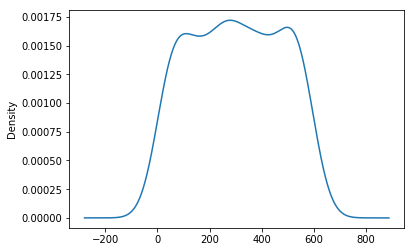

In [74]:
user_data.loc[user_data['mobile'] == False, 'time_on_site'].plot.density()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [188]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd

path = 'persons.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0'])

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)